# How best to run a CURN model

In [1]:
import discovery as ds
import jax
import numpy as np
import jax.numpy as jnp
import glob
from pathlib import Path
import discovery as ds
import discovery.samplers.numpyro as ds_numpyro
import matplotlib.pyplot as plt

In [2]:
datapath = Path(ds.__path__[0]) / '../../data'

In [3]:
psrs = [ds.Pulsar.read_feather(f) for f in sorted(datapath.glob('*v1p1*.feather'))][:10] # only 10 pulsars for now

## Making the model 
{func}`~discovery.signals.make_combined_crn` will combine intrinsic red noise and common noise
into a single GP that can use a single Fourier basis.
Since this fixes the names of the common process when it's created, we also return those parameters
so you can pass them later on.

If you want different Fourier bases (different T-spans) for different pulsars or for different noise processes, then
you will have to do something different.

In [4]:

# common_parnames are the names of parameters
# that are shared for all pulsars.
mypl, common_parnames = ds.make_combined_crn(14, ds.powerlaw, ds.powerlaw, crn_prefix='gw_')

psls = [ds.PulsarLikelihood([psr.residuals,
                             ds.makenoise_measurement(psr, psr.noisedict),
                             ds.makegp_ecorr(psr, psr.noisedict),
                             ds.makegp_timing(psr, svd=True)]) for psr in psrs]

commongp = ds.makecommongp_fourier(psrs, mypl, 30, T=ds.getspan(psrs), name='red_noise',
                                   common=common_parnames)

array_likelihood = ds.ArrayLikelihood(psls, commongp=commongp)

In [5]:
jlogl = jax.jit(array_likelihood.logL)

## Variable transformations and performance
This does a transformation so that the parameters that get sampled
live on the full real line instead of uniform in a fixed range
this helps with NUTS sampling.

ATTENTION!!! In creating this transformed likelihood, JAX
actually bypasses the parameter dictionary completely
when it is compiled. This seems to give a large performance benefit on GPUs, where the dictionary
rolling and unrolling seems to cause significant overhead.

For both the sampling reasons, and this performance reasons, I'd recommend using these transformations if possible. 

In [6]:
# create a numpyro model with the transformed likelihood
npmodel = ds_numpyro.makemodel_transformed(jlogl)
#
npsampler = ds_numpyro.makesampler_nuts(npmodel,
                                        num_warmup=100,
                                        num_samples=100)

In [7]:
npsampler.run(jax.random.key(0))
chain = npsampler.to_df()
# chain.to_csv('chain.feather', index=False)

sample: 100%|██████████| 200/200 [00:32<00:00,  6.11it/s, 63 steps of size 7.64e-02. acc. prob=0.94]


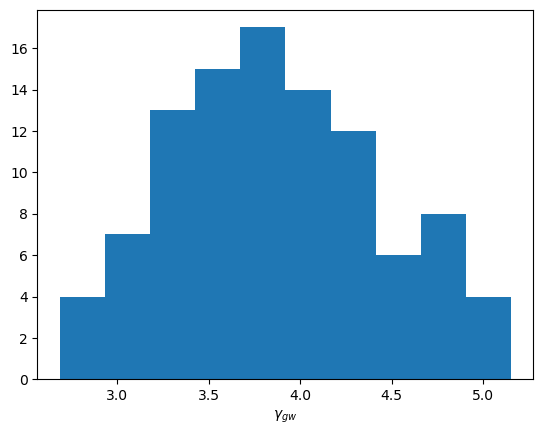

In [8]:
plt.hist(chain['gw_gamma'])
plt.xlabel("$\gamma_{gw}$")
plt.show()